In [1]:
import tensorflow
import keras
import numpy as np
import matplotlib.pyplot as plt

#from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, SeparableConv2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.applications import imagenet_utils
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

from model import conv_block, depthwise_conv_block
#from keras.utils import get_file
#from keras.utils import layer_utils

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


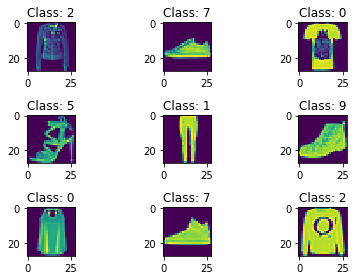

In [2]:
# Load the Fashion MNIST dataset
# Though we're using Keras to import the data, you are free
# to use any deep learning framework you wish.
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# Add empty color dimension
x_train = np.expand_dims(x_train, -1)  # shape: (num_samples, 28, 28, 1)
#print(x_train[0])
x_test = np.expand_dims(x_test, -1) # shape: (num_samples, 28, 28, 1)
# Plot a few examples. Note that the images are black and white and
# that the labels are provided as integer values 0-9.
num_examples = 9
indexes = np.random.randint(x_train.shape[0], size=(num_examples))

dim = int(np.sqrt(num_examples))

fig = plt.figure()
k = 1
for idx in indexes:
    ax = fig.add_subplot(dim, dim, k)
    ax.imshow(x_train[idx][:, :, 0])
    ax.set_title('Class: %d' % y_train[idx])
    k += 1
fig.tight_layout()
# Preprocess the image to format each pixel to range [0, 1)
x_train = x_train/255.0
x_test = x_test/255.0
# Express labels as one-hot vectors
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)

In [3]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"
# Modify this cell to complete the functions below.
def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '_'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)
    print("x: ", x.get_shape)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = BatchNormalization()(left)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = BatchNormalization()(right)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)
    print("left: ", left.get_shape)
    print("right: ", right.get_shape)
    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

def depthwise_fire_module(x, fire_id, squeeze=16, expand=64, depth_multiplier = 1, alpha=1.0):
    s_id = 'fire' + str(fire_id) + '/'
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = conv_block(x, squeeze, kernel=(1,1), name=s_id +sq1x1, alpha=alpha)
    print("x: ", x.get_shape)
    left = conv_block(x, expand, name=s_id + exp1x1, alpha=alpha)
    right = depthwise_conv_block(x, expand, name=s_id+exp3x3, depth_multiplier=depth_multiplier, alpha=alpha)
    print("left: ", left.get_shape)
    print("right: ", right.get_shape)
    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

In [11]:
def SqueezeNet(input_shape=(28,28,1), n_classes=10):
    img_input = Input(shape=input_shape)

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    #x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    #Header of the imagenet model
    x = Dropout(0.5, name='drop9')(x)
    x = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(inputs=img_input, outputs=x, name='squeezenet')
    return model

def DepthwiseSqueezeNet(input_shape=(28,28,1), n_classes=10, depth_multiplier=1, alpha=1.0):
    
    img_input = Input(shape=input_shape)
    
    x = conv_block(img_input, 64, alpha, strides=(2,2))
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='pool1')(x)
    
    x = depthwise_fire_module(x, fire_id=2, squeeze=16, expand=64, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=3, squeeze=16, expand=64, depth_multiplier=depth_multiplier)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = depthwise_fire_module(x, fire_id=4, squeeze=32, expand=128, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=5, squeeze=32, expand=128, depth_multiplier=depth_multiplier)
    #x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = depthwise_fire_module(x, fire_id=6, squeeze=48, expand=192, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=7, squeeze=48, expand=192, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=8, squeeze=64, expand=256, depth_multiplier=depth_multiplier)
    x = depthwise_fire_module(x, fire_id=9, squeeze=64, expand=256, depth_multiplier=depth_multiplier)
    
    #Header of the imagenet model
    x = Dropout(0.5, name='drop9')(x)
    #x = depthwise_conv_block(x, n_classes, depth_multiplier=depth_multiplier, name='header')
    x = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(inputs=img_input, outputs=x, name='depthwise_squeezenet')
    return model

In [6]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 1)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_3:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_2/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_2/convolution:0' shape=(?, 15, 15, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_2/cond/Merge:0' shape=(?, 15, 15, 64) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_1/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_1/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_1/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_1/cond/Merge:0' shape=(?, 7,

left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_1/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/expand3x3pointwise_conv_relu_1/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_1/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_1/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_1/convolution:0' shape=(?, 3, 3, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_bn_1/cond/Merge:0' shape=(?, 3, 3, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_relu_1/Relu6:0' shape=(?, 3, 3, 64) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'conv

In [12]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 1, alpha=0.75)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_8:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_7/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_7/convolution:0' shape=(?, 15, 15, 48) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_7/cond/Merge:0' shape=(?, 15, 15, 48) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_6/MaxPool:0' shape=(?, 7, 7, 48) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_6/MaxPool:0' shape=(?, 7, 7, 48) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_6/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_6/cond/Merge:0' shape=(?, 7,

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_6/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_6/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/expand3x3pointwise_conv_relu_6/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_6/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_6/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_6/convolution:0' shape=(?, 3, 3, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_bn_6/cond/Merge:0' shape=(?, 3, 3, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 

In [13]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 1, alpha=0.5)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_9:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_8/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_8/convolution:0' shape=(?, 15, 15, 32) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_8/cond/Merge:0' shape=(?, 15, 15, 32) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_7/MaxPool:0' shape=(?, 7, 7, 32) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_7/MaxPool:0' shape=(?, 7, 7, 32) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_7/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_7/cond/Merge:0' shape=(?, 7,

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_7/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_7/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/expand3x3pointwise_conv_relu_7/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_7/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_7/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_7/convolution:0' shape=(?, 3, 3, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_bn_7/cond/Merge:0' shape=(?, 3, 3, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 

In [14]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 1, alpha=0.25)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_10:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_9/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_9/convolution:0' shape=(?, 15, 15, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_9/cond/Merge:0' shape=(?, 15, 15, 16) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_8/MaxPool:0' shape=(?, 7, 7, 16) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_8/MaxPool:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_8/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_8/cond/Merge:0' shape=(?, 7

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_8/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_8/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/expand3x3pointwise_conv_relu_8/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_8/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_8/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_8/convolution:0' shape=(?, 3, 3, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_bn_8/cond/Merge:0' shape=(?, 3, 3, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 

In [16]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 5)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_12:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_10/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_11/convolution:0' shape=(?, 15, 15, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_10/cond/Merge:0' shape=(?, 15, 15, 64) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_10/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_10/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_9/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_9/cond/Merge:0' shape=

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_9/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_9/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/expand3x3pointwise_conv_relu_9/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_9/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_9/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_9/convolution:0' shape=(?, 3, 3, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_bn_9/cond/Merge:0' shape=(?, 3, 3, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 

In [17]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 25)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_13:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_11/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_12/convolution:0' shape=(?, 15, 15, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_11/cond/Merge:0' shape=(?, 15, 15, 64) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_11/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_11/MaxPool:0' shape=(?, 7, 7, 64) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_10/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_10/cond/Merge:0' shap

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_10/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_10/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/expand3x3pointwise_conv_relu_10/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_10/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_10/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_10/convolution:0' shape=(?, 3, 3, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_bn_10/cond/Merge:0' shape=(?, 3, 3, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.

In [18]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 5, alpha=0.75)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_14:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_12/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_13/convolution:0' shape=(?, 15, 15, 48) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_12/cond/Merge:0' shape=(?, 15, 15, 48) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_12/MaxPool:0' shape=(?, 7, 7, 48) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_12/MaxPool:0' shape=(?, 7, 7, 48) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_11/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_11/cond/Merge:0' shap

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_11/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_11/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/expand3x3pointwise_conv_relu_11/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_11/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_11/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_11/convolution:0' shape=(?, 3, 3, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_bn_11/cond/Merge:0' shape=(?, 3, 3, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.

In [19]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 25, alpha=0.75)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_15:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_13/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_14/convolution:0' shape=(?, 15, 15, 48) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_13/cond/Merge:0' shape=(?, 15, 15, 48) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_13/MaxPool:0' shape=(?, 7, 7, 48) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_13/MaxPool:0' shape=(?, 7, 7, 48) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_12/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_12/cond/Merge:0' shap

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_12/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_12/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/expand3x3pointwise_conv_relu_12/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_12/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_12/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_12/convolution:0' shape=(?, 3, 3, 64) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_bn_12/cond/Merge:0' shape=(?, 3, 3, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.

In [20]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 5, alpha=0.50)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_16:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_14/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_15/convolution:0' shape=(?, 15, 15, 32) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_14/cond/Merge:0' shape=(?, 15, 15, 32) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_14/MaxPool:0' shape=(?, 7, 7, 32) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_14/MaxPool:0' shape=(?, 7, 7, 32) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_13/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_13/cond/Merge:0' shap

conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_13/convolution:0' shape=(?, 3, 3, 192) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_13/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_13/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/expand3x3pointwise_conv_relu_13/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_13/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'fire7/concat_13/concat:0' shape=(?, 3, 3, 384) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire8/squeeze1x1_13/convolution:0' shape=(?, 3, 3, 64) dtype=float32>>
conv after bn:  <bound method Tenso

In [21]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 25, alpha=0.50)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_17:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_15/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_16/convolution:0' shape=(?, 15, 15, 32) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_15/cond/Merge:0' shape=(?, 15, 15, 32) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_15/MaxPool:0' shape=(?, 7, 7, 32) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_15/MaxPool:0' shape=(?, 7, 7, 32) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_14/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_14/cond/Merge:0' shap

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_bn_14/cond/Merge:0' shape=(?, 3, 3, 48) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_relu_14/Relu6:0' shape=(?, 3, 3, 48) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_relu_14/Relu6:0' shape=(?, 3, 3, 48) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_relu_14/Relu6:0' shape=(?, 3, 3, 48) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_14/convolution:0' shape=(?, 3, 3, 192) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_14/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_14/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_s

In [22]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 5, alpha=0.25)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_18:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_16/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_17/convolution:0' shape=(?, 15, 15, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_16/cond/Merge:0' shape=(?, 15, 15, 16) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_16/MaxPool:0' shape=(?, 7, 7, 16) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_16/MaxPool:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_15/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_15/cond/Merge:0' shap

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_bn_15/cond/Merge:0' shape=(?, 3, 3, 48) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_relu_15/Relu6:0' shape=(?, 3, 3, 48) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_relu_15/Relu6:0' shape=(?, 3, 3, 48) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_relu_15/Relu6:0' shape=(?, 3, 3, 48) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_15/convolution:0' shape=(?, 3, 3, 192) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_15/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_15/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_s

In [23]:
depthwise_squeeze_model = DepthwiseSqueezeNet(depth_multiplier= 25, alpha=0.25)
depthwise_squeeze_model.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
depthwise_squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'input_19:0' shape=(?, 28, 28, 1) dtype=float32>>
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_pad_17/Pad:0' shape=(?, 29, 29, 1) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_18/convolution:0' shape=(?, 15, 15, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'conv1_bn_17/cond/Merge:0' shape=(?, 15, 15, 16) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_17/MaxPool:0' shape=(?, 7, 7, 16) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'pool1_17/MaxPool:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_16/convolution:0' shape=(?, 7, 7, 16) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire2/squeeze1x1_bn_16/cond/Merge:0' shap

conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_bn_16/cond/Merge:0' shape=(?, 3, 3, 48) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_relu_16/Relu6:0' shape=(?, 3, 3, 48) dtype=float32>>
conv inputs:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_relu_16/Relu6:0' shape=(?, 3, 3, 48) dtype=float32>>
Stride is (1,1)
conv after padding:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/squeeze1x1_relu_16/Relu6:0' shape=(?, 3, 3, 48) dtype=float32>>
conv after convolution:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_16/convolution:0' shape=(?, 3, 3, 192) dtype=float32>>
conv after bn:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_bn_16/cond/Merge:0' shape=(?, 3, 3, 192) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'convfire7/expand1x1_relu_16/Relu6:0' shape=(?, 3, 3, 192) dtype=float32>>
right:  <bound method Tensor.get_s

In [15]:
squeeze_model = SqueezeNet()
squeeze_model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
squeeze_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

x:  <bound method Tensor.get_shape of <tf.Tensor 'fire2_relu_squeeze1x1/Relu:0' shape=(?, 6, 6, 16) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'fire2_relu_expand1x1/Relu:0' shape=(?, 6, 6, 64) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire2_relu_expand3x3/Relu:0' shape=(?, 6, 6, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 'fire3_relu_squeeze1x1/Relu:0' shape=(?, 6, 6, 16) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'fire3_relu_expand1x1/Relu:0' shape=(?, 6, 6, 64) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire3_relu_expand3x3/Relu:0' shape=(?, 6, 6, 64) dtype=float32>>
x:  <bound method Tensor.get_shape of <tf.Tensor 'fire4_relu_squeeze1x1/Relu:0' shape=(?, 2, 2, 32) dtype=float32>>
left:  <bound method Tensor.get_shape of <tf.Tensor 'fire4_relu_expand1x1/Relu:0' shape=(?, 2, 2, 128) dtype=float32>>
right:  <bound method Tensor.get_shape of <tf.Tensor 'fire4